In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import dataloader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.datasets import fetch_lfw_pairs
lfw_pairs_train = fetch_lfw_pairs(subset='train')

print(list(lfw_pairs_train.target_names))

print(lfw_pairs_train.pairs.shape)

print(lfw_pairs_train.data.shape)

print(lfw_pairs_train.target.shape)

lfw_pairs_test = fetch_lfw_pairs(subset='test')

list(lfw_pairs_test.target_names), lfw_pairs_test.pairs.shape, lfw_pairs_test.data.shape, lfw_pairs_test.target.shape, lfw_pairs_test.target_names


[np.str_('Different persons'), np.str_('Same person')]
(2200, 2, 62, 47)
(2200, 5828)
(2200,)


([np.str_('Different persons'), np.str_('Same person')],
 (1000, 2, 62, 47),
 (1000, 5828),
 (1000,),
 array(['Different persons', 'Same person'], dtype='<U17'))

In [ ]:
Xtrain, Xtest, ytrain, ytest = lfw_pairs_train.data, lfw_pairs_test.data, lfw_pairs_train.target, lfw_pairs_test.target

Xtrain.shape

(2200, 5828)

In [ ]:
class FacialRecog(nn.Module):
    def __init__(self):
        super(FacialRecog, self).__init__()
        # The model expects 3-channel input images.
        self.x1layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)))
        # The model expects 3-channel input images.
        self.x2layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)))
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 1),
            nn.Sigmoid())
    def forward(self, x1, x2):
        x1 = self.x1layers(x1)
        x2 = self.x2layers(x2)
        x = torch.cat((x1, x2), dim=1)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [ ]:
model = FacialRecog()
model.to(device)

FacialRecog(
  (x1layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters: {total_params}')

Total trainable parameters: 2723201


In [ ]:
from torch.utils.data import Dataset, DataLoader

class LFWDataset(Dataset):
    def __init__(self, pairs, targets, transform=None):
        self.pairs = pairs
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1, img2 = self.pairs[idx]
        target = self.targets[idx]

        img1 = img1.reshape(62, 47)
        img2 = img2.reshape(62, 47)

        img1 = np.stack([img1, img1, img1], axis=0)
        img2 = np.stack([img2, img2, img2], axis=0)

        img1 = torch.from_numpy(img1).float()
        img2 = torch.from_numpy(img2).float()

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return (img1, img2), torch.tensor(target, dtype=torch.float32)


train_dataset = LFWDataset(lfw_pairs_train.pairs, lfw_pairs_train.target)
test_dataset = LFWDataset(lfw_pairs_test.pairs, lfw_pairs_test.target)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        accuracy = 0.0
        correct = 0
        total = 0
        for inputs, labels in dataloader:
            inputs1, inputs2 = inputs
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs1, inputs2)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            preds = (outputs.squeeze() > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item() * labels.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        accuracy = correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        print(f'Accuracy: {accuracy:.4f}')

train_model(model, train_dataloader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.5933
Accuracy: 0.6864
Epoch 2/10, Loss: 0.5763
Accuracy: 0.7091
Epoch 3/10, Loss: 0.5783
Accuracy: 0.7064
Epoch 4/10, Loss: 0.5597
Accuracy: 0.7264
Epoch 5/10, Loss: 0.5463
Accuracy: 0.7373
Epoch 6/10, Loss: 0.5481
Accuracy: 0.7323
Epoch 7/10, Loss: 0.5282
Accuracy: 0.7418
Epoch 8/10, Loss: 0.5212
Accuracy: 0.7464
Epoch 9/10, Loss: 0.5286
Accuracy: 0.7409
Epoch 10/10, Loss: 0.5105
Accuracy: 0.7536


In [ ]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for inputs, labels in test_dataloader:
    inputs1, inputs2 = inputs
    inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
    outputs = model(inputs1, inputs2)
    preds = (outputs.squeeze() > 0.5).float()
    correct += (preds == labels).sum().item()
    total += labels.size(0)
accuracy = correct / total
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6080


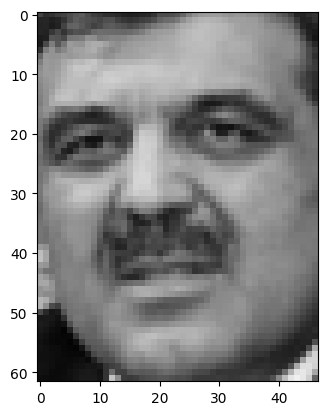

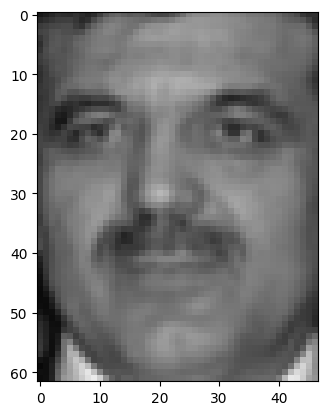

In [ ]:
for inputs, labels in test_dataloader:
  # Move tensor to CPU and permute dimensions for matplotlib
  plt.imshow(inputs[0][0].to('cpu').permute(1, 2, 0), cmap='viridis')
  plt.show()
  plt.imshow(inputs[1][0].to('cpu').permute(1, 2, 0), cmap='viridis')
  plt.show()
  break